# Load Data

## Load Peeringdb

In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


## Load data from Clickhouse

In [9]:
import clickhouse_connect

client = clickhouse_connect.get_client(host='localhost', port=8123, username='default', password='')

query = """
/* Gewichtetes Zentrum + Distanzverteilung (in Metern) */
WITH base AS (
    SELECT
        asn,
        latitude,
        longitude,
        (ip_end - ip_start + 1)::UInt64 AS w          -- Gewicht = Anzahl IPs
    FROM ip_location_asn
    WHERE ip_version = 4
    AND origin = 'ipinfo'
),
-- 1️⃣  Gewichtete 3D-Vektoren -> sphärisches Zentrum
vec AS (
    SELECT
        asn,
        sum(w * cos(radians(latitude)) * cos(radians(longitude))) AS X,
        sum(w * cos(radians(latitude)) * sin(radians(longitude))) AS Y,
        sum(w * sin(radians(latitude)))                           AS Z,
        sum(w)                                                    AS W
    FROM base
    GROUP BY asn
),
center AS (
    SELECT
        asn,
        degrees(atan2(Y, X))                       AS center_lon,
        degrees(atan2(Z, sqrt(X*X + Y*Y)))         AS center_lat
    FROM vec
),
joined AS (
    SELECT
        b.asn,
        b.w,
        c.center_lat,
        c.center_lon,
        greatCircleDistance(b.longitude, b.latitude, c.center_lon, c.center_lat) AS d_m
    FROM base AS b
    INNER JOIN center AS c USING (asn)
)
SELECT
    asn,
    center_lat,
    center_lon,
    sum(w)                                                   AS total_weight,
    round(avgWeighted(d_m, w), 1)                            AS mean_m,
    round(quantileExactWeighted(0.5)(d_m, w), 1)             AS p50_m,
    round(quantileExactWeighted(0.9)(d_m, w), 1)             AS p90_m,
    round(quantileExactWeighted(0.99)(d_m, w), 1)            AS p99_m,
    round(max(d_m), 1)                                       AS max_m,
    round(sqrt(avgWeighted(pow(d_m, 2), w)
               - pow(avgWeighted(d_m, w), 2)), 1)            AS std_m_weighted
FROM joined
GROUP BY
    asn, center_lat, center_lon
ORDER BY asn
"""

ch_df = client.query_df(query)
ch_df.head()

,asn,center_lat,center_lon,total_weight,mean_m,p50_m,p90_m,p99_m,max_m,std_m_weighted
0,1,25.968005,92.578899,78170880,244434.7,202409.6,270881.4,2174951.9,16533529.8,285174.3
1,2,33.230429,-61.914181,86016,3183716.0,1427955.7,8556521.7,11221176.5,11221176.5,3305595.2
2,3,42.494470,-76.065844,46607360,702519.0,411166.6,1267015.7,3906494.2,15164766.9,NaN
3,4,39.845247,-77.498175,162816,436469.2,112862.3,112862.3,12790216.7,12790216.7,1800104.5
4,5,36.125222,-113.401780,2304,1767134.0,801168.8,9527867.3,9527867.3,9527867.3,2743852.2


## Join the dataframes

In [10]:
joined = net_df.merge(ch_df, on='asn', how='left')
joined.fillna(0, inplace=True)
joined.head()


,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,status,center_lat,center_lon,total_weight,mean_m,p50_m,p90_m,p99_m,max_m,std_m_weighted
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,ok,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,ok,41.321808,-81.861514,8.605195e+10,1264627.6,662509.7,3440840.6,6319630.8,18126772.9,0.0
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,ok,73.672117,-13.819731,1.382400e+04,3095707.4,2079777.0,5511552.6,5511552.6,5511552.6,1567609.2
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,ok,47.081346,7.876276,3.653532e+09,76689.9,59958.8,124588.5,167131.0,6641842.7,0.0
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,ok,36.385780,-93.351135,1.031810e+10,1205014.8,873863.0,1960305.9,2401693.8,14417213.8,0.0


# Get Stats as Plots

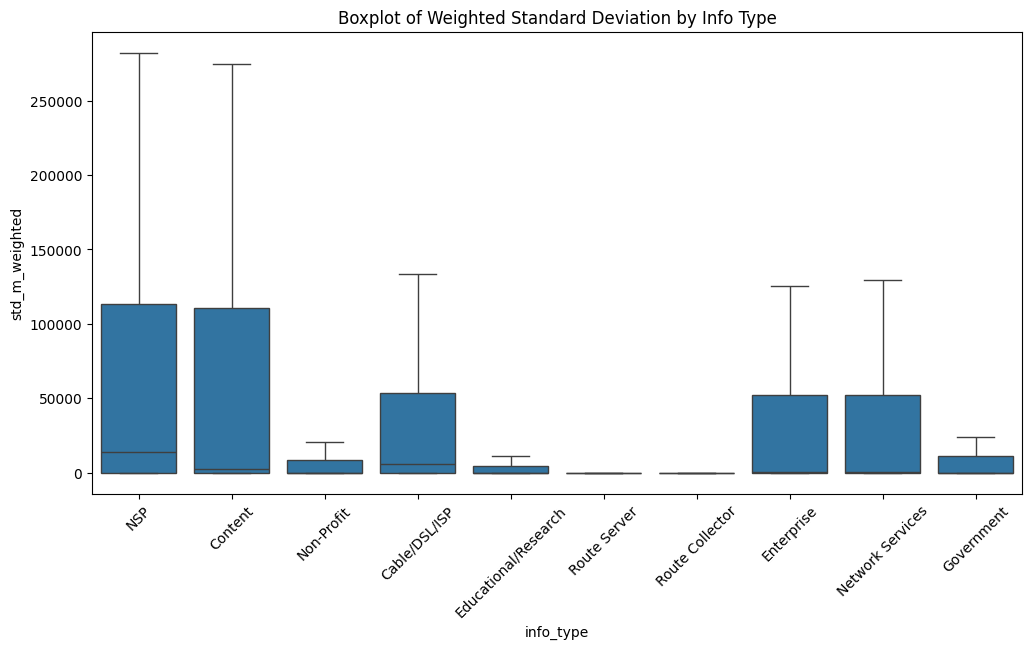

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where std_m_weighted is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['std_m_weighted'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='std_m_weighted', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Standard Deviation by Info Type')
plt.show()

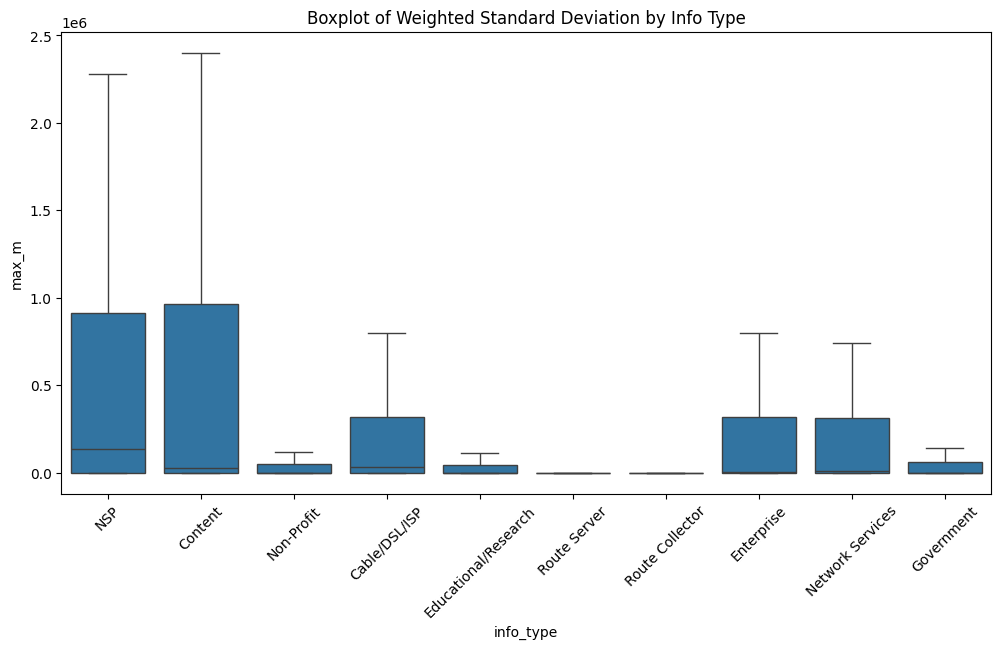

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['max_m'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='max_m', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Maximum Deviation by Info Type')
plt.show()